In [1]:
# This code is to test a trained dq stepper in the 2d case
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#for live plotting
from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline

%run 2d_lipm_env.ipynb #imports LIPM Env

[0.   0.04 0.09 0.13 0.16 0.19 0.24 0.29 0.35]
[0.   0.03 0.06 0.1  0.13 0.15 0.17 0.2  0.23 0.26 0.3  0.35]


In [2]:
class NN(nn.Module):
    def __init__(self, inp_size, out_size):
        
        super(NN, self).__init__()
        self.l1 = nn.Linear(inp_size, 512)
        self.l2 = nn.Linear(512, 512)
        self.l3 = nn.Linear(512, 512)
        self.l4 = nn.Linear(512, 512)
        self.l5 = nn.Linear(512, 512)
        self.l6 = nn.Linear(512, 512)
        self.l7 = nn.Linear(512, 512)
        self.l8 = nn.Linear(512, out_size)
    
    def forward(self, x):
        
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        x = F.relu(self.l5(x))
        x = F.relu(self.l6(x))
        x = F.relu(self.l7(x))
        x = self.l8(x)
        return x

In [3]:
class TwoDQStepper:
    def __init__(self, no_actions = [9, 7], lr = 1e-4, gamma = 0.9, use_tarnet = False, trained_model = None):
        '''
        This is a 2d dq stepper.
        State = [x-ux, y - uy, xd, yd, n, action_x, action_y]
        '''
        self.device = torch.device("cpu")
        self.dq_stepper = NN(9, 1).to(self.device) #state+ action -> q_value
        if trained_model:
            self.dq_stepper.load_state_dict(torch.load(trained_model))
            self.dq_stepper.eval()
        self.optimizer = torch.optim.SGD(self.dq_stepper.parameters(), lr)
        self.use_tarnet = use_tarnet
        if self.use_tarnet:
            self.dq_tar_stepper = NN(9, 1).to(self.device)
            self.dq_tar_stepper.load_state_dict(self.dq_stepper.state_dict())
            self.dq_tar_stepper.eval()
        self.gamma = gamma #discount factor
        assert len(no_actions) == 2
        self.no_actions = no_actions
        
        # This is the template of x_in that goes into the dq stepper
        self.x_in = np.zeros((self.no_actions[0]*self.no_actions[1], 9))
        self.x_in[:,7] = np.tile(np.arange(self.no_actions[0]), self.no_actions[1])
        self.x_in[:,8] = np.repeat(np.arange(self.no_actions[1]), self.no_actions[0])
                  
    def predict_action_value(self, x):
        # this function predicts the q_value for different actions and returns action and min q value
        self.x_in[:,[0, 1, 2, 3, 4, 5, 6]] = x
        torch_x_in = torch.FloatTensor(self.x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_stepper(torch_x_in).detach().numpy()
            action_index = np.argmin(q_values)
            action_x = int(action_index%self.no_actions[0])
            action_y = int(action_index//self.no_actions[0])
        return [action_x, action_y], q_values[action_index]
    
    def tar_predict_action_value(self, x):
        # this function uses tar net to predict 
        # the q_value for different actions and returns action and min q value
        self.x_in[:,[0, 1, 2, 3, 4, 5, 6]] = x
        torch_x_in = torch.FloatTensor(self.x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_tar_stepper(torch_x_in).detach().numpy()
            action_index = np.argmin(q_values)
            action_x = int(action_index%self.no_actions[0])
            action_y = int(action_index//self.no_actions[0])
        return [action_x, action_y], q_values[action_index]
    
    def predict_eps_greedy(self, x, eps = 0.1):
        # This function returns prediction based on epsillon greedy algorithm
        if np.random.random() > eps:
            return self.predict_action_value(x)[0]
        else:
            action_x = np.random.randint(self.no_actions[0])
            action_y = np.random.randint(self.no_actions[1])
            return [action_x, action_y]
        
    def optimize(self, mini_batch, tau = 0.001):
        # This function performs one step of back propogation for the given mini_batch data
        x_in = torch.FloatTensor(mini_batch[:,0:9].copy(), device = self.device)
        y_train = torch.FloatTensor(mini_batch[:,9].copy(), device = self.device)
        for i in range(len(mini_batch)):
            if not np.isnan(mini_batch[i,10:]).all():
                if not self.use_tarnet:
                    y_train[i] += self.gamma * self.predict_action_value(mini_batch[i,10:])[1]
                else:
                    y_train[i] += self.gamma * self.tar_predict_action_value(mini_batch[i,10:])[1]

        y_train = y_train.unsqueeze(1).detach() #ensures that gradients are not computed on this
        x_train = self.dq_stepper(x_in)

        loss = F.mse_loss(x_train, y_train)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        if self.use_tarnet:
            for tar_param, param in zip(self.dq_tar_stepper.parameters(), self.dq_stepper.parameters()):
                tar_param.data.copy_(tar_param.data * (1.0 - tau) + param.data * tau)
                
        return loss
    
    def live_plot(self, history, figsize=(7,5), title='history'):
        clear_output(wait=True)
        plt.figure(figsize=figsize)
        for label,data in history.items():
            plt.plot(data, label=label)
        plt.title(title)
        plt.grid(True)
        plt.xlabel('episode')
        plt.ylim(0, 200)
        plt.legend(loc='top right') # the plot evolves to the right
        plt.show();
        
    def predict_q(self, x):
        #for debugging
        # this function predicts the q_value for different actions and returns action and min q value
        self.x_in[:,[0, 1, 2, 3, 4, 5, 6]] = x
        torch_x_in = torch.FloatTensor(self.x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_stepper(torch_x_in).detach().numpy()
        return q_values

In [4]:
env = TwoDLipmEnv(0.2, 0.13, 0.22, [1, 3, 0], no_actions= [11, 9])
no_actions = [len(env.action_space_x), len(env.action_space_y)]
print(no_actions)

dqs = TwoDQStepper(lr=1e-4, gamma=0.98, use_tarnet= True, no_actions= no_actions, trained_model='../../models/twod/dqs_2')

[11, 9]


0.04283529368781193 0.0 0.026964498683434757


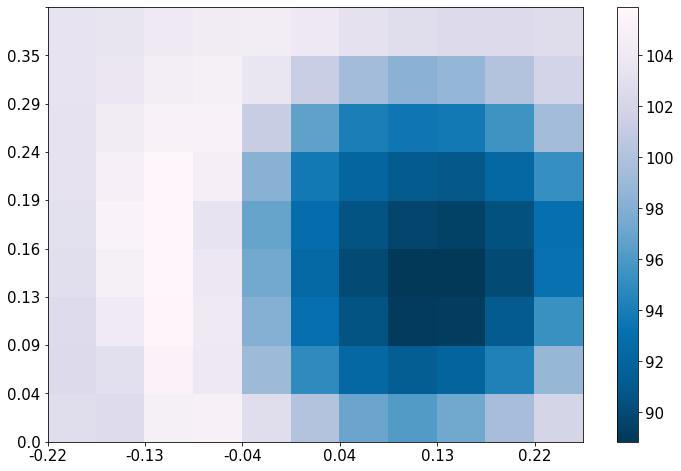

In [20]:
# This block is for visualising the output from the dqstepper
def compute_dcm(state, ht):
    return state[0] + np.sqrt(ht/9.81)*state[1]

def infinite_capture_radius(step_time, max_step_length, ht):
    delta_t = np.sqrt((9.81*step_time)/ht)
    return max_step_length*(np.power(np.e, -delta_t))/(1 - np.power(np.e, -delta_t))

def plot_heatmap(x1, dqs, env):
    plt.rcParams.update({'font.size': 15})
    q = dqs.predict_q(x1)
    n = dqs.no_actions
    q_mat = np.zeros((n[1], n[0]))
    for i in range(len(q)):
        q_mat[int(dqs.x_in[i,8]), int(dqs.x_in[i,7])] = q[i]
    dcm_x = compute_dcm([x1[0], x1[2]], 0.2)
    dcm_y = compute_dcm([x1[1], x1[3]], 0.2)
    fig, ax = plt.subplots(figsize = (12,8))
#     ax.axvline(x=6, color = 'red')
#     ax.axhline(y=dcm_y, color = 'red')
    print(dcm_x, dcm_y, infinite_capture_radius(0.1, 0.22, 0.2))
    ax.set_xticklabels(env.action_space_x[::2])
    ax.set_yticklabels(env.action_space_y)
    heatmap = ax.pcolor(q_mat, cmap='PuBu_r')
    fig.colorbar(heatmap, ax=ax)
    plt.show()

x1 = [0, 0, 0.3, 0, 1, 0, 0]
# x2 = [0, 0, 0, 0, 1, 0, 0]

plot_heatmap(x1, dqs, env)
# plot_heatmap(x2, dqs)

In [72]:
# This block animates the stepper 
no_steps = 20
step_time = 0.1
v_des = [-1.0, 0]
v_init = [0.5, 0.0]
state = env.reset_env([0.0, 0.0, v_init[0], v_init[1]], v_des, no_steps*step_time)
print(state)
epi_cost = 0
for n in range(no_steps):
    action = dqs.predict_action_value(state)[0]
    next_state, cost, done = env.step_env(action, step_time)
    print(action, cost, done, state[0:4])
    epi_cost += cost
    state = next_state
    if done:
        print(epi_cost)
        break
print("showing episode...")
env.show_episode(5)

[ 0.   0.   0.5  0.   1.  -1.   0. ]
[10, 4] 6.092185928227927 False [0.  0.  0.5 0. ]
[3, 3] 2.811307493497181 False [-0.17 -0.08  0.63  0.34]
[5, 5] 3.1041239652004546 False [-0.05  0.07 -0.1   0.01]
[2, 4] 0.5831740394357158 False [-0.07 -0.1  -0.39  0.38]
[1, 5] 1.3846430256220508 False [-0.    0.07 -0.87 -0.06]
[3, 4] 0.6991482844610764 False [ 0.08 -0.1  -1.11  0.31]
[4, 3] 0.9896348635323493 False [ 0.07  0.06 -0.95 -0.16]
[3, 4] 1.0618680708696995 False [ 0.03 -0.07 -0.81  0.13]
[3, 4] 1.013745862999213 False [ 0.04  0.09 -0.87 -0.2 ]
[3, 3] 0.7218420765047154 False [ 0.04 -0.07 -0.89  0.21]
[3, 3] 1.0246674066514034 False [ 0.05  0.06 -0.89 -0.11]
[3, 3] 0.9423225723694763 False [ 0.05 -0.06 -0.87  0.19]
[4, 4] 1.7593696808264907 False [ 0.06  0.07 -0.81 -0.1 ]
[4, 3] 1.283964394532687 False [ 0.03 -0.08 -0.68  0.25]
[3, 3] 0.9281486937286988 False [ 0.    0.05 -0.69 -0.12]
[3, 3] 0.8086391080171087 False [ 0.02 -0.07 -0.85  0.15]
[1, 2] 0.3817644744881168 False [ 0.02  0.05 -

CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '432x288', '-pix_fmt', 'rgba', '-r', '40.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmp_j9rijnm/temp.m4v']' returned non-zero exit status 255.

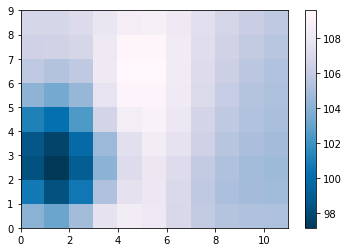

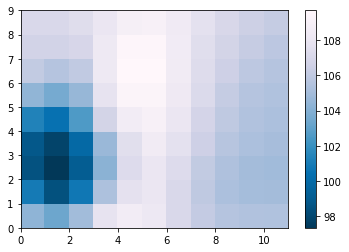

In [7]:
# This block creates the regularizing matrix
no_actions = [len(env.action_space_x), len(env.action_space_y)]
q_mat = np.zeros((no_actions[1], no_actions[0]))
reg_mat = np.zeros((no_actions[1], no_actions[0]))

for y in range(reg_mat.shape[0]):
    for x in range(reg_mat.shape[1]):
        reg_mat[y][x] = np.linalg.norm([env.action_space_x[x], env.action_space_y[y] - env.b])
        
def plot_reg_heatmap(x1, dqs, w):
    q = dqs.predict_q(x1)
    n = dqs.no_actions
    q_mat = np.zeros((n[1], n[0]))
    for i in range(len(q)):
        q_mat[int(dqs.x_in[i,8]), int(dqs.x_in[i,7])] = q[i]
    q_mat += w*reg_mat
    fig, ax = plt.subplots()
    heatmap = ax.pcolor(q_mat, cmap='PuBu_r')
    fig.colorbar(heatmap, ax=ax)
    plt.show()

x1 = [0, 0, -1, 0, -1, 0, 0]

plot_reg_heatmap(x1, dqs, 0)
plot_reg_heatmap(x1, dqs, 1)
